# Задание 5
повторить эксперимент с предобучением моделей denoising-автокодировщика и без предобучения (рисунок 3 из статьи).

Гребенькова Ольга Сергеевна, М05-104

In [1]:
import torch
import os
import time
from torch import nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt

Создадим сначала денойзинг автоэнкодер, который обучается по слоям. То есть они не связаны во время обучения.

In [2]:
class CDAutoEncoder(nn.Module):
    """
    Convolutional denoising autoencoder layer for stacked autoencoders.
    This module is automatically trained when in model.training is True.
    Args:
        input_size: The number of features in the input
        output_size: The number of features to output
        stride: Stride of the convolutional layers.
    """
    def __init__(self, input_size, output_size, stride):
        super(CDAutoEncoder, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=5, stride=stride, padding=0),
            nn.ReLU(),
        )
        self.backward_pass = nn.Sequential(
            nn.ConvTranspose2d(output_size, input_size, kernel_size=5, stride=stride, padding=0), 
            nn.ReLU(),
        )

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

    def forward(self, x):
        # Train each autoencoder individually
        x = x.clone().detach()
        # Add noise, but use the original input as the target.
        x_noisy = x + torch.randn(x.size()).to(device) * 0.1
        y = self.forward_pass(x_noisy)

        if self.training:
            x_reconstruct = self.backward_pass(y)
            loss = self.criterion(x_reconstruct, x.data)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        return y.detach()

    def reconstruct(self, x):
        return self.backward_pass(x)


class StackedAutoEncoder(nn.Module):
    """
    A stacked autoencoder made from the convolutional denoising autoencoders above.
    Each autoencoder is trained independently and at the same time.
    """

    def __init__(self):
        super(StackedAutoEncoder, self).__init__()

        self.ae1 = CDAutoEncoder(1, 128, 1)
        self.ae2 = CDAutoEncoder(128, 256, 1)
        self.ae3 = CDAutoEncoder(256, 512, 1)

    def forward(self, x):
        a1 = self.ae1(x)
        a2 = self.ae2(a1)
        a3 = self.ae3(a2)

        if self.training:
            return a3

        else:
            return a3, self.reconstruct(a3)

    def reconstruct(self, x):
            a2_reconstruct = self.ae3.reconstruct(x)
            a1_reconstruct = self.ae2.reconstruct(a2_reconstruct)
            x_reconstruct = self.ae1.reconstruct(a1_reconstruct)
            return x_reconstruct

Загрузка датасета. И создание модели.

In [3]:
if not os.path.exists('./imgs'):
    os.mkdir('./imgs')

def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

num_epochs = 5
batch_size = 1024
device = 'cuda:0'

train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
    
                              ]))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
model = StackedAutoEncoder().to(device)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



Тренируем все отдельно (pretrained) и следим за лоссом.

In [4]:
pretrain = []
classifier = nn.Linear(512*256, 10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(train_loader):
        img, target = data
        target = target.to(device)
        img = img.to(device)
        features = model(img).detach()
        prediction = classifier(features.view(-1, 512*256))
        loss = criterion(prediction, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            img, target = data
            target = target.to(device)
            img = img.to(device)
            features, x_reconstructed = model(img)
            reconstruction_loss = torch.mean((x_reconstructed.data - img.data)**2)
            prediction = classifier(features.view(-1, 512*256))
            loss = criterion(prediction, target)
            pred = prediction.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            orig = to_img(img.cpu().data)
            save_image(orig, './imgs/orig_{}.png'.format(epoch))
            pic = to_img(x_reconstructed.cpu().data)
            save_image(pic, './imgs/reconstruction_{}.png'.format(epoch))
    

        print("Epoch {} complete\t\tLoss: {:.4f}".format(epoch, reconstruction_loss))
        print("Linear classifier performance: {}/{} = {:.2f}%".format(correct, len(test_loader)*batch_size, 100*float(correct) / (len(test_loader)*batch_size)))
        pretrain.append(loss.item())
        print("="*80)
    

torch.save(model.state_dict(), './CDAE.pth')

Epoch 0 complete		Loss: 0.9246
Linear classifier performance: 2576/10240 = 25.16%
Epoch 1 complete		Loss: 0.9246
Linear classifier performance: 5483/10240 = 53.54%
Epoch 2 complete		Loss: 0.9246
Linear classifier performance: 6455/10240 = 63.04%
Epoch 3 complete		Loss: 0.9246
Linear classifier performance: 8250/10240 = 80.57%
Epoch 4 complete		Loss: 0.9246
Linear classifier performance: 8995/10240 = 87.84%


Теперь создадим архитектуру, которая учится совместно.

In [5]:
class CDAutoEncoder_no_ind_train(nn.Module):
    """
    Convolutional denoising autoencoder layer for stacked autoencoders. TRAIN ENODER version.
    This module is automatically trained when in model.training is True.
    Args:
        input_size: The number of features in the input
        output_size: The number of features to output
        stride: Stride of the convolutional layers.
    """
    def __init__(self, input_size, output_size, stride):
        super(CDAutoEncoder_no_ind_train, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=5, stride=stride, padding=0),
            nn.ReLU(),
        )
        self.backward_pass = nn.Sequential(
            nn.ConvTranspose2d(output_size, input_size, kernel_size=5, stride=stride, padding=0), 
            nn.ReLU(),
        )

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

    def forward(self, x):
        # Not now! Train each autoencoder individually
        #x = x.clone().detach()
        # Add noise, but use the original input as the target.
        #x_noisy = x + torch.randn(x.size()).to(device) * 0.1
        y = self.forward_pass(x)
            
        return y

    def reconstruct(self, x):
        return self.backward_pass(x)
    
class StackedAutoEncoder_no_ind_train(nn.Module):
    """
    A stacked autoencoder made from the convolutional denoising autoencoders above.
    Each autoencoder is trained independently and at the same time.
    """

    def __init__(self):
        super(StackedAutoEncoder_no_ind_train, self).__init__()

        self.ae1 = CDAutoEncoder_no_ind_train(1, 128, 1)
        self.ae2 = CDAutoEncoder_no_ind_train(128, 256, 1)
        self.ae3 = CDAutoEncoder_no_ind_train(256, 512, 1)

    def forward(self, x):
        a1 = self.ae1(x)
        a2 = self.ae2(a1)
        a3 = self.ae3(a2)

        return a3

    def reconstruct(self, x):
            a2_reconstruct = self.ae3.reconstruct(x)
            a1_reconstruct = self.ae2.reconstruct(a2_reconstruct)
            x_reconstruct = self.ae1.reconstruct(a1_reconstruct)
            return x_reconstruct

Теперь будем доучивать модель как обычно в течении еще 5 эпох. Для этого загрузим веса в обычную модель.

In [6]:
pretrained_model = StackedAutoEncoder_no_ind_train().to(device)
pretrained_model.load_state_dict(torch.load('./CDAE.pth'))

<All keys matched successfully>

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(classifier.parameters()) +list(pretrained_model.parameters()), lr=0.001)
for epoch in range(num_epochs):
    pretrained_model.train()
    for i, data in enumerate(train_loader):
        img, target = data
        target = target.to(device)
        img = img.to(device)
        features = pretrained_model(img)
        prediction = classifier(features.view(-1, 512*256))
        loss = criterion(prediction, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    pretrained_model.eval()
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            img, target = data
            target = target.to(device)
            img = img.to(device)
            features = pretrained_model(img)
            prediction = classifier(features.view(-1, 512*256))
            loss = criterion(prediction, target)
            pred = prediction.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            
        print("Linear classifier performance: {}/{} = {:.2f}%".format(correct, len(test_loader)*batch_size, 100*float(correct) / (len(test_loader)*batch_size)))
        pretrain.append(loss.item())
        print("="*80)
    

#torch.save(model.state_dict(), './CDAE.pth')

Linear classifier performance: 9459/10240 = 92.37%
Linear classifier performance: 9748/10240 = 95.20%
Linear classifier performance: 9791/10240 = 95.62%
Linear classifier performance: 9836/10240 = 96.05%
Linear classifier performance: 9839/10240 = 96.08%


Теперь обучим обычную модель с 0 в течении 10 эпох.

In [8]:
notrain_model = StackedAutoEncoder_no_ind_train().to(device)
train_loss = []
classifier = nn.Linear(512*256, 10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(classifier.parameters()) + list(notrain_model.parameters()), lr=0.001)
for epoch in range(2*num_epochs):
    notrain_model.train()
    for i, data in enumerate(train_loader):
        img, target = data
        target = target.to(device)
        img = img.to(device)
        features = notrain_model(img)
        prediction = classifier(features.view(-1, 512*256))
        loss = criterion(prediction, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    notrain_model.eval()
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            img, target = data
            target = target.to(device)
            img = img.to(device)
            features = notrain_model(img)
            prediction = classifier(features.view(-1, 512*256))
            loss = criterion(prediction, target)
            pred = prediction.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
  

        print("Linear classifier performance: {}/{} = {:.2f}%".format(correct, len(test_loader)*batch_size, 100*float(correct) / (len(test_loader)*batch_size)))
        train_loss.append(loss.item())
        print("="*80)
    

torch.save(notrain_model.state_dict(), './no_train_CDAE.pth')

Linear classifier performance: 9820/10240 = 95.90%
Linear classifier performance: 9868/10240 = 96.37%
Linear classifier performance: 9854/10240 = 96.23%
Linear classifier performance: 9871/10240 = 96.40%
Linear classifier performance: 9889/10240 = 96.57%
Linear classifier performance: 9883/10240 = 96.51%
Linear classifier performance: 9898/10240 = 96.66%
Linear classifier performance: 9913/10240 = 96.81%
Linear classifier performance: 9899/10240 = 96.67%
Linear classifier performance: 9904/10240 = 96.72%


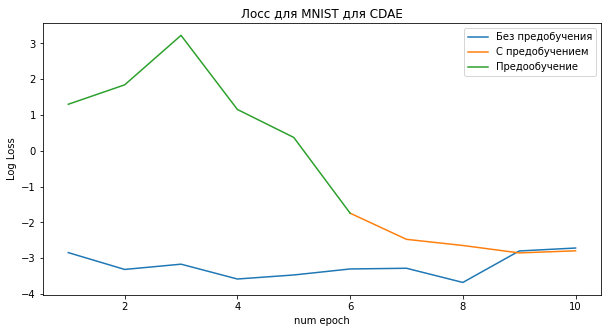

In [9]:
plt.figure(figsize=(10,5))
plt.plot(range(1,11), np.log(train_loss), label='Без предобучения')
plt.plot(range(6,11), np.log(pretrain[5:]), label='C предобучением')
plt.plot(range(1,7), np.log(pretrain[:6]), label='Предообучение')
plt.title('Лосс для MNIST для CDAE')
plt.xlabel('num epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

### ВЫВОД

Судя по всему данный эффект работает не всегда и зависит в том числе от классификатора. У нас достаточно большая модель и маленький датасет. Возможно для получения похожих результатов нужен или более сложный датасет (к примеру, CIFAR-10 и соответственно больше времени для обучения и гпу) или упрощать архитектуру. Тем не менее за тоже время получились схожие результаты, даже чуть лучше. Так что претрейн точно не ухудшает модель.